# Hotel booking

## Content:
### 1. EDA

The dataset contains data from two different hotels. One Resort hotel and one City hotel.

The data contains "bookings due to arrive between the 1st of July of 2015 and the 31st of August 2017".  
Note: For most questions I will only use bookings that were not canceled, to get acutal guest numbers. As you will see, this is quite a big difference.

Topics covered and questions to answer from the data:
- Where do the guests come from?
- How much do guests pay for a room per night?
- How does the price per night vary over the year?
- Which are the most busy month?
- How long do people stay at the hotels?
- Bookings by market segment



Setup, data inspection and cleanup are hidden for easier reading. Click the Code/Output buttons if you are curious.

In [ ]:
# Setup

# common:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import folium

# set some display options:
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 36)

# load data:
file_path = "hotel_bookings.csv"
full_data = pd.read_csv(file_path)

In [ ]:
# A bit of data inspection and cleanup, I did most of the inspectin seperately
full_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
# check for missing values
full_data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [ ]:
# Replace missing values:
# agent: If no agency is given, booking was most likely made without one.
# company: If none given, it was most likely private.
# rest schould be self-explanatory.
nan_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
full_data_cln = full_data.fillna(nan_replacements)

# "meal" contains values "Undefined", which is equal to SC.
full_data_cln["meal"].replace("Undefined", "SC", inplace=True)

# Some rows contain entreis with 0 adults, 0 children and 0 babies.
# I'm dropping these entries with no guests.
zero_guests = list(full_data_cln.loc[full_data_cln["adults"]
                   + full_data_cln["children"]
                   + full_data_cln["babies"]==0].index)
full_data_cln.drop(full_data_cln.index[zero_guests], inplace=True)

In [ ]:
# How much data is left?
full_data_cln.shape

(119210, 32)

In [ ]:
full_data_cln

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0,0.0,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0.0,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,0.0,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,0.0,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,0.0,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,0.0,0,Transient,104.40,0,0,Check-Out,2017-09-07


## 1. EDA

In [ ]:
# After cleaning, separate Resort and City hotel
# To know the acutal visitor numbers, only bookings that were not canceled are included.
rh = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel") & (full_data_cln["is_canceled"] == 0)]
ch = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel") & (full_data_cln["is_canceled"] == 0)]

### How does the price per night vary over the year?  
To keep it simple, I'm using the average price per night and person, regardless of the room type and meal.  

<ipython-input-30-b464ce18e864>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x = "arrival_date_month", y="adr", hue="hotel", data=room_prices_mothly,


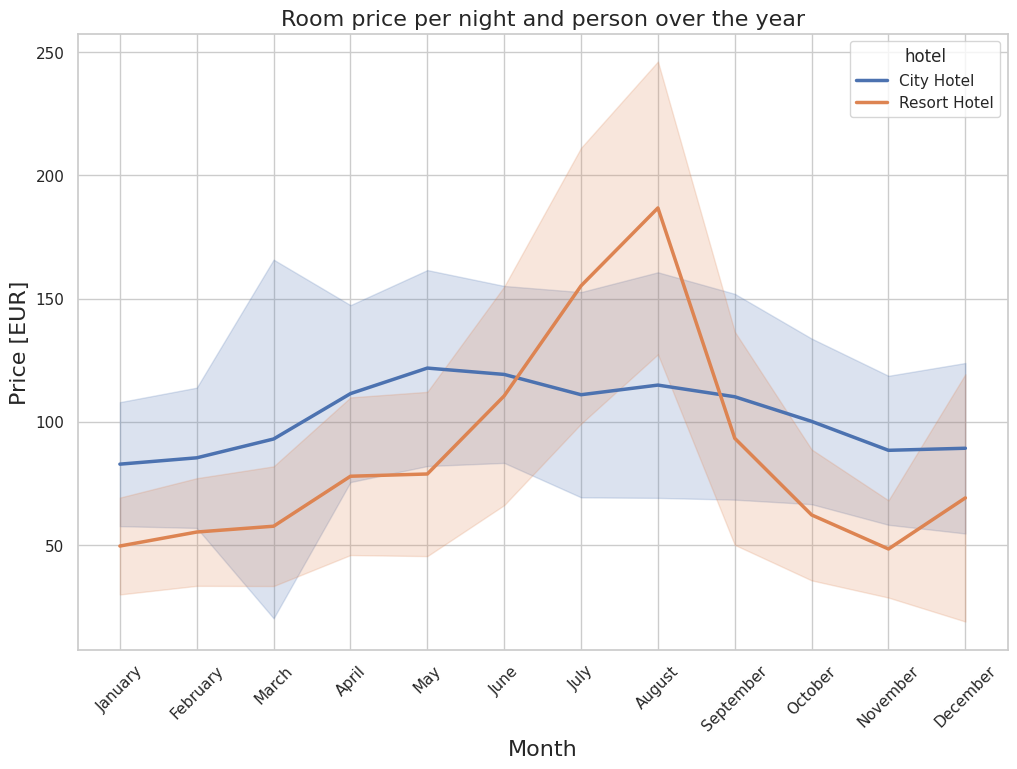

In [ ]:
# grab data:
room_prices_mothly = full_data_cln[["hotel", "arrival_date_month", "adr"]].sort_values("arrival_date_month")

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]
room_prices_mothly["arrival_date_month"] = pd.Categorical(room_prices_mothly["arrival_date_month"], categories=ordered_months, ordered=True)

# barplot with standard deviation:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "arrival_date_month", y="adr", hue="hotel", data=room_prices_mothly,
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Room price per night and person over the year", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Price [EUR]", fontsize=16)
plt.show()

This clearly shows that the prices in the Resort hotel are much higher during the summer (no surprise here).   
The price of the city hotel varies less and is most expensive during spring and autumn.

### Which are the most busy month?

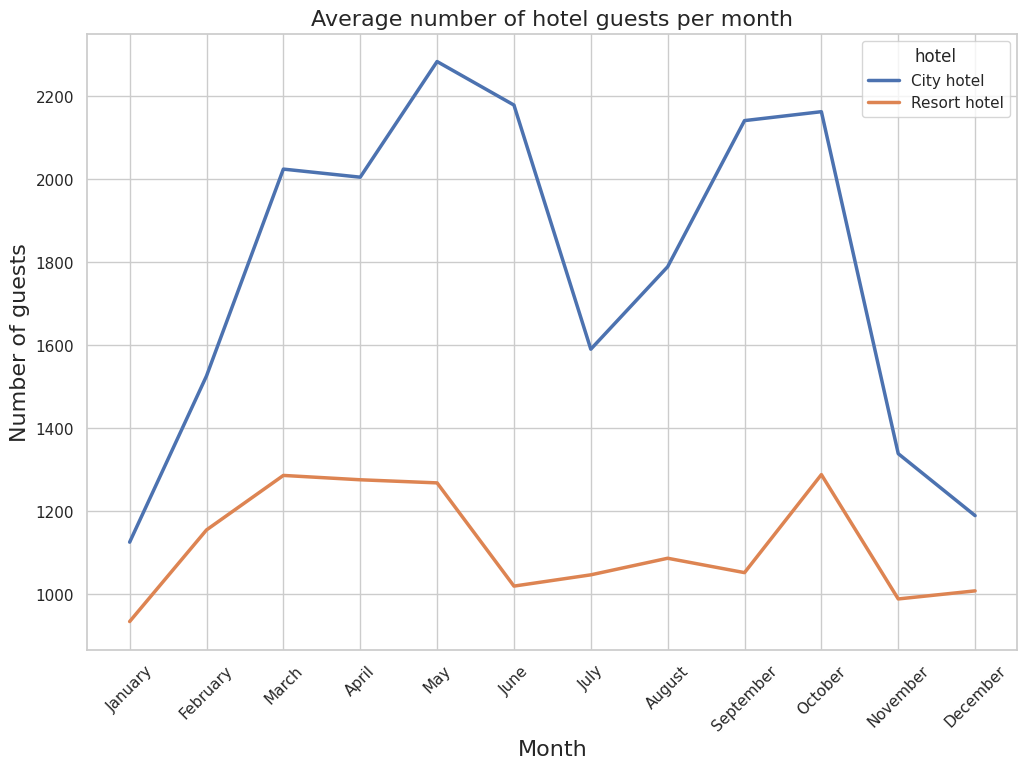

In [ ]:
# Create a DateFrame with the relevant data:
resort_guests_monthly = rh.groupby("arrival_date_month")["hotel"].count()
city_guests_monthly = ch.groupby("arrival_date_month")["hotel"].count()

resort_guest_data = pd.DataFrame({"month": list(resort_guests_monthly.index),
                    "hotel": "Resort hotel",
                    "guests": list(resort_guests_monthly.values)})

city_guest_data = pd.DataFrame({"month": list(city_guests_monthly.index),
                    "hotel": "City hotel",
                    "guests": list(city_guests_monthly.values)})
full_guest_data = pd.concat([resort_guest_data,city_guest_data], ignore_index=True)

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]
full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories=ordered_months, ordered=True)

# Dataset contains July and August date from 3 years, the other month from 2 years. Normalize data:
full_guest_data.loc[(full_guest_data["month"] == "July") | (full_guest_data["month"] == "August"),
                    "guests"] /= 3
full_guest_data.loc[~((full_guest_data["month"] == "July") | (full_guest_data["month"] == "August")),
                    "guests"] /= 2

#show figure:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "month", y="guests", hue="hotel", data=full_guest_data,
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Average number of hotel guests per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of guests", fontsize=16)
plt.show()

The City hotel has more guests during spring and autumn, when the prices are also highest.   
In July and August there are less visitors, although prices are lower.  

Guest numbers for the Resort hotel go down slighty from June to September, which is also when the prices are highest.  
Both hotels have the fewest guests during the winter.

### How long do people stay at the hotels?

In [ ]:
# Create a DateFrame with the relevant data:
rh["total_nights"] = rh["stays_in_weekend_nights"] + rh["stays_in_week_nights"]
ch["total_nights"] = ch["stays_in_weekend_nights"] + ch["stays_in_week_nights"]

num_nights_res = list(rh["total_nights"].value_counts().index)
num_bookings_res = list(rh["total_nights"].value_counts())
rel_bookings_res = rh["total_nights"].value_counts() / sum(num_bookings_res) * 100 # convert to percent

num_nights_cty = list(ch["total_nights"].value_counts().index)
num_bookings_cty = list(ch["total_nights"].value_counts())
rel_bookings_cty = ch["total_nights"].value_counts() / sum(num_bookings_cty) * 100 # convert to percent

res_nights = pd.DataFrame({"hotel": "Resort hotel",
                           "num_nights": num_nights_res,
                           "rel_num_bookings": rel_bookings_res})

cty_nights = pd.DataFrame({"hotel": "City hotel",
                           "num_nights": num_nights_cty,
                           "rel_num_bookings": rel_bookings_cty})

nights_data = pd.concat([res_nights, cty_nights], ignore_index=True)

<ipython-input-17-283ede7f468b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rh["total_nights"] = rh["stays_in_weekend_nights"] + rh["stays_in_week_nights"]
<ipython-input-17-283ede7f468b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ch["total_nights"] = ch["stays_in_weekend_nights"] + ch["stays_in_week_nights"]


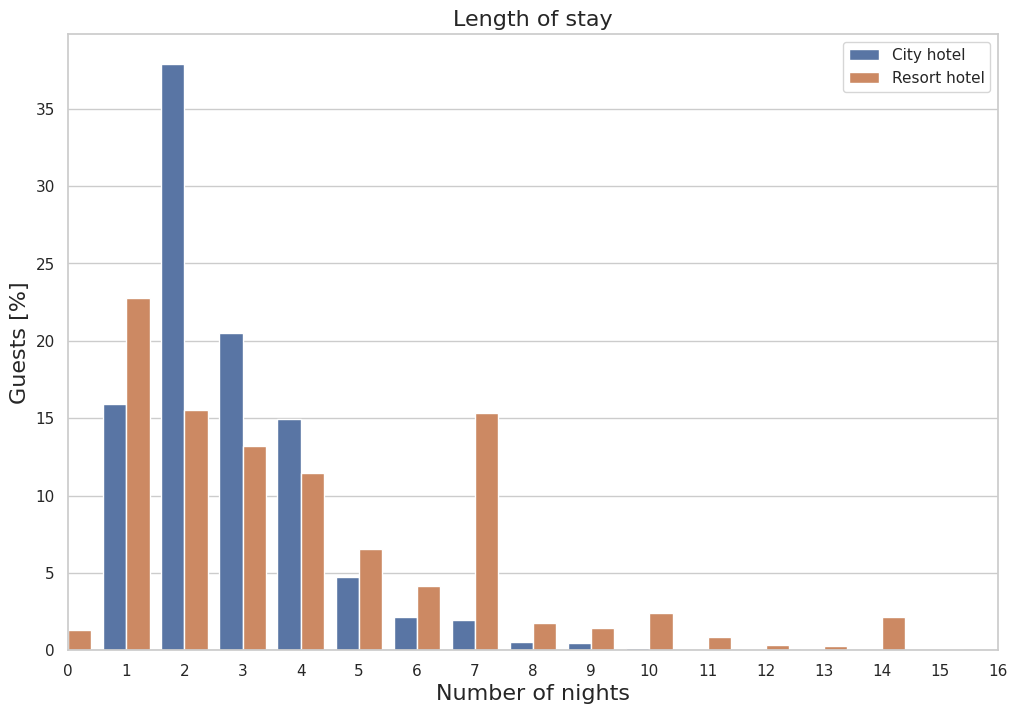

In [ ]:
#show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x = "num_nights", y = "rel_num_bookings", hue="hotel", data=nights_data,
            hue_order = ["City hotel", "Resort hotel"])
plt.title("Length of stay", fontsize=16)
plt.xlabel("Number of nights", fontsize=16)
plt.ylabel("Guests [%]", fontsize=16)
plt.legend(loc="upper right")
plt.xlim(0,16)
plt.show()

In [ ]:
avg_nights_res = sum(list((res_nights["num_nights"] * (res_nights["rel_num_bookings"]/100)).values))
avg_nights_cty = sum(list((cty_nights["num_nights"] * (cty_nights["rel_num_bookings"]/100)).values))
print(f"On average, guests of the City hotel stay {avg_nights_cty:.2f} nights, and {cty_nights['num_nights'].max()} at maximum.")
print(f"On average, guests of the Resort hotel stay {avg_nights_res:.2f} nights, and {res_nights['num_nights'].max()} at maximum.")

On average, guests of the City hotel stay 2.92 nights, and 48 at maximum.
On average, guests of the Resort hotel stay 4.14 nights, and 69 at maximum.


For the city hotel there is a clear preference for 1-4 nights.  
For the resort hotel, 1-4 nights are also often booked, but 7 nights also stand out as being very popular.

### Bookings by market segment

In [ ]:
# total bookings per market segment (incl. canceled)
segments=full_data_cln["market_segment"].value_counts()

# pie plot
fig = px.pie(segments,
             values=segments.values,
             names=segments.index,
             title="Bookings per market segment",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

### How many bookings were canceled?

In [ ]:
# absolute cancelations:
total_cancelations = full_data_cln["is_canceled"].sum()
rh_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"]["is_canceled"].sum()
ch_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"]["is_canceled"].sum()

# as percent:
rel_cancel = total_cancelations / full_data_cln.shape[0] * 100
rh_rel_cancel = rh_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"].shape[0] * 100
ch_rel_cancel = ch_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"].shape[0] * 100

print(f"Total bookings canceled: {total_cancelations:,} ({rel_cancel:.0f} %)")
print(f"Resort hotel bookings canceled: {rh_cancelations:,} ({rh_rel_cancel:.0f} %)")
print(f"City hotel bookings canceled: {ch_cancelations:,} ({ch_rel_cancel:.0f} %)")

Total bookings canceled: 44,199 (37 %)
Resort hotel bookings canceled: 11,120 (28 %)
City hotel bookings canceled: 33,079 (42 %)


### Which month have the highest number of cancelations?

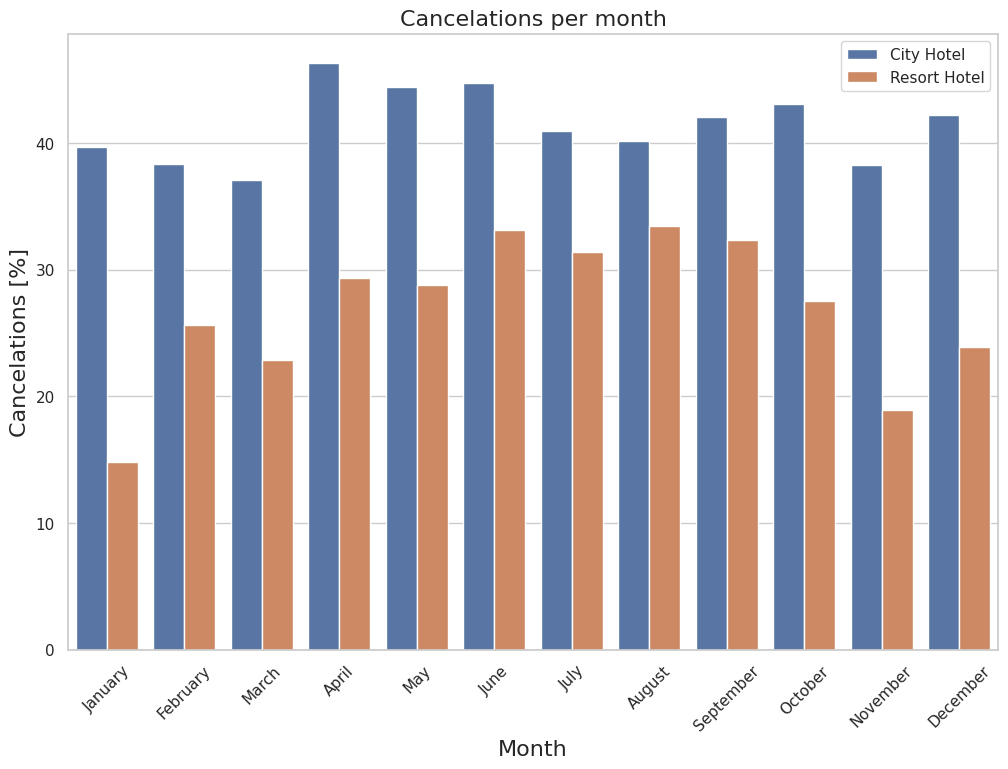

In [ ]:
# Create a DateFrame with the relevant data:
res_book_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

cty_book_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
cty_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})
cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(cty_book_per_month.index),
                                "Bookings": list(cty_book_per_month.values),
                                "Cancelations": list(cty_cancel_per_month.values)})

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "cancel_percent" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=full_cancel_data)
plt.title("Cancelations per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.legend(loc="upper right")
plt.show()

For the City hotel the relative number of cancelations is around 40 % throughout the year.  
For the Resort hotel it is highest in the summer and lowest during the winter.

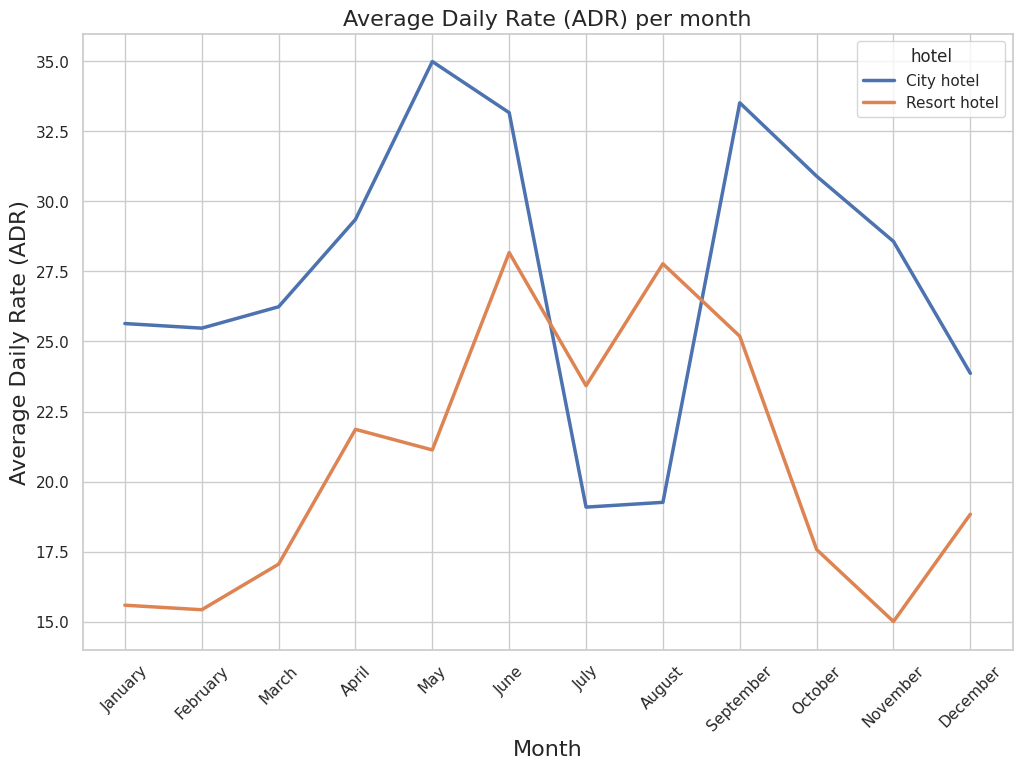

In [ ]:
resort_adr_monthly = rh.groupby("arrival_date_month")["adr_pp"].mean()
city_adr_monthly = ch.groupby("arrival_date_month")["adr_pp"].mean()

resort_adr_data = pd.DataFrame({"month": list(resort_adr_monthly.index),
                                "hotel": "Resort hotel",
                                "adr_pp": list(resort_adr_monthly.values)})

city_adr_data = pd.DataFrame({"month": list(city_adr_monthly.index),
                              "hotel": "City hotel",
                              "adr_pp": list(city_adr_monthly.values)})
full_adr_data = pd.concat([resort_adr_data, city_adr_data], ignore_index=True)

# Ordering by month:
ordered_months = ["January", "February", "March", "April", "May", "June",
                  "July", "August", "September", "October", "November", "December"]
full_adr_data["month"] = pd.Categorical(full_adr_data["month"], categories=ordered_months, ordered=True)

# Normalize data if necessary, based on your specific dataset conditions.
# Assuming the dataset condition for normalization is similar to the guest count example:
full_adr_data.loc[(full_adr_data["month"] == "July") | (full_adr_data["month"] == "August"), "adr_pp"] /= 3
full_adr_data.loc[~((full_adr_data["month"] == "July") | (full_adr_data["month"] == "August")), "adr_pp"] /= 2

# Plotting the figure:
plt.figure(figsize=(12, 8))
sns.lineplot(x="month", y="adr_pp", hue="hotel", data=full_adr_data,
             hue_order=["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Average Daily Rate (ADR) per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Average Daily Rate (ADR)", fontsize=16)
plt.show()

<ipython-input-42-0f1ba74a0f20>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



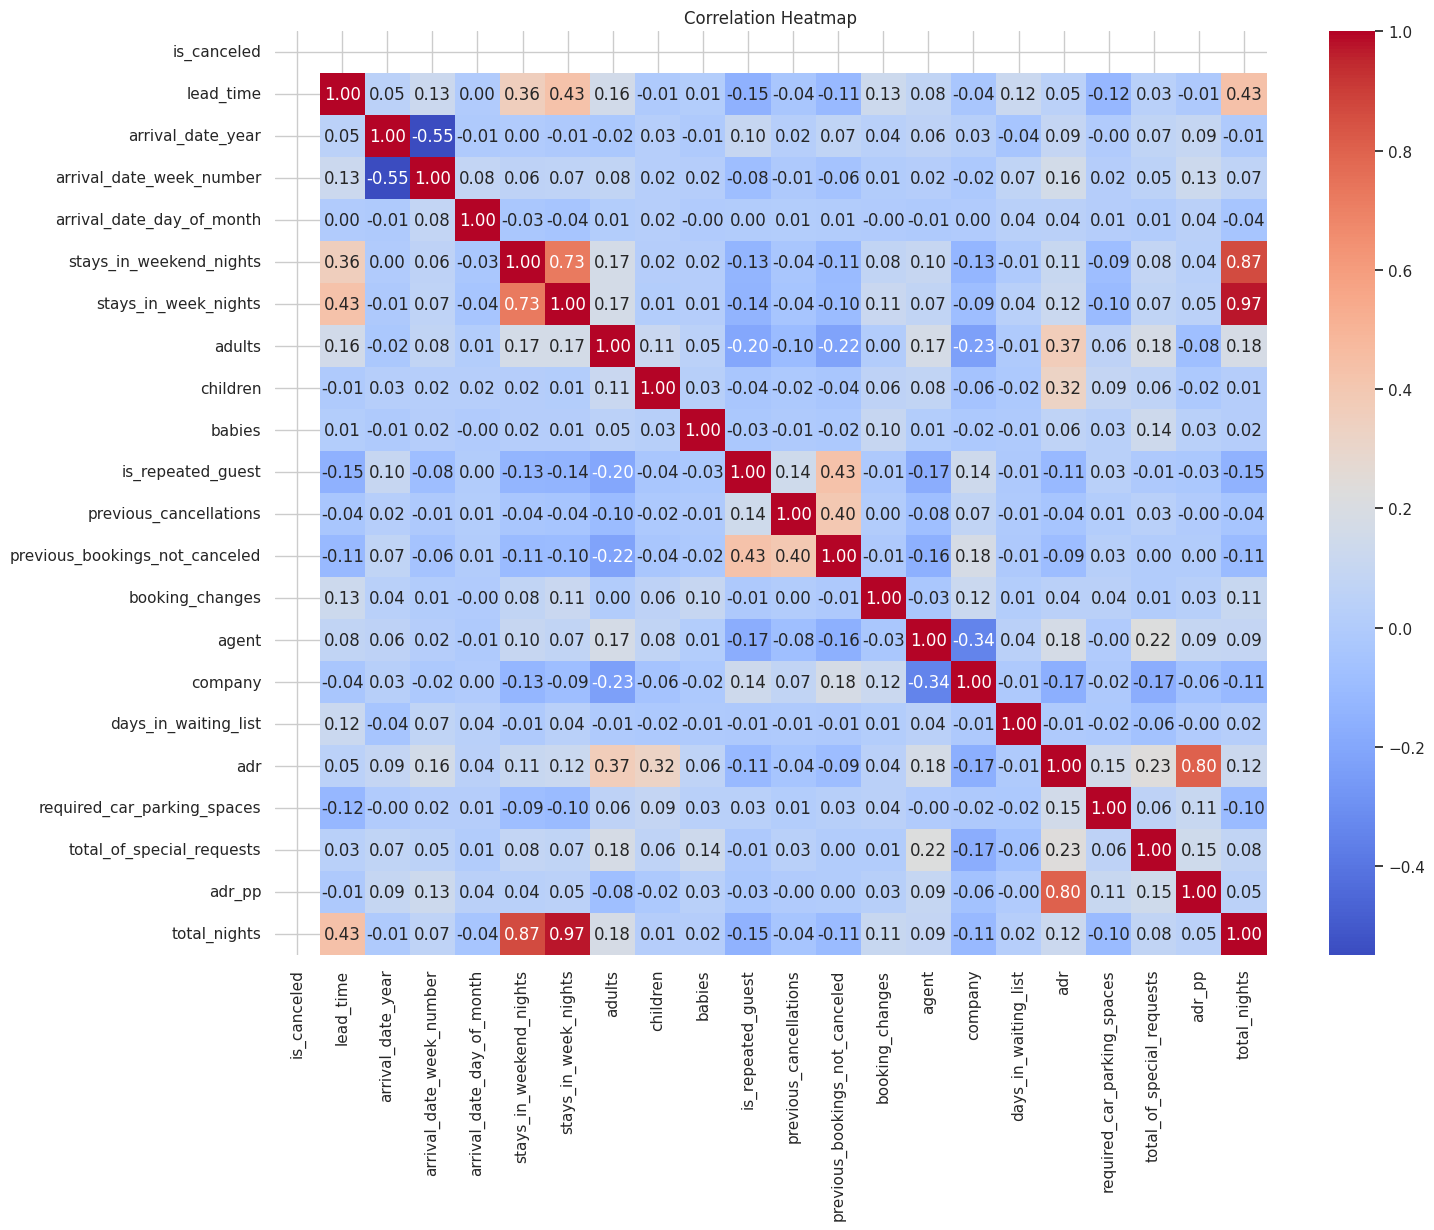

In [ ]:

# Compute the correlation matrix
correlation_matrix = rh.corr()

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()